In [7]:
!pip install category_encoders

     ---------------------------------------- 81.2/81.2 kB 4.4 MB/s eta 0:00:00


In [9]:
!pip install imblearn

     -------------------------------------- 226.0/226.0 kB 4.6 MB/s eta 0:00:00
     -------------------------------------- 298.0/298.0 kB 9.3 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


In [12]:
!pip install xgboost

     --------------------------------------- 89.1/89.1 MB 28.4 MB/s eta 0:00:00


In [1]:
import platform
platform.platform()

'Windows-10-10.0.19045-SP0'

In [2]:
!nvidia-smi

Fri Feb 24 00:41:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.24       Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   53C    P8     4W /  89W |   3391MiB /  4096MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!python --version

Python 3.9.13


In [4]:
import pandas as pd
import random
import os
import numpy as np
import warnings
import matplotlib.pylab as plt
import seaborn as sns

In [5]:
from tqdm.notebook import tqdm
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split, cross_val_score, cross_validate
from sklearn.feature_selection import SelectPercentile
warnings.filterwarnings('ignore')

In [6]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
import category_encoders as ce
from imblearn.over_sampling import BorderlineSMOTE

In [7]:
from sklearn.ensemble import BaggingClassifier , GradientBoostingClassifier, VotingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [8]:
class CFG:
    SEED = 26
    
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG.SEED)

In [9]:
DATA_PATH = './open/'
train = pd.read_csv(DATA_PATH + 'train.csv')
test = pd.read_csv(DATA_PATH + 'test.csv')
snp = pd.read_csv(DATA_PATH + 'snp_info.csv')

In [10]:
def get_x_y(df):
    if 'class' in df.columns:
        df_x = df.drop(columns = ['id','class'])
        df_y = df['class']
        return df_x , df_y
    else:
        df_x = df.drop(columns= ['id'])
        return df_x
train_x , train_y = get_x_y(train)
test_x = get_x_y(test)

<AxesSubplot:xlabel='class', ylabel='count'>

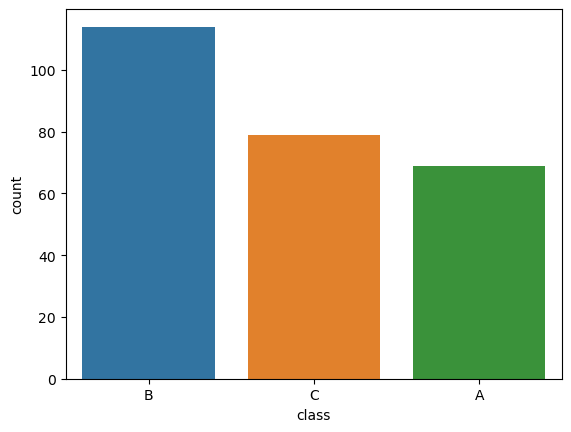

In [11]:
sns.countplot(train_y)

In [12]:
train_x = train_x.drop(columns = ['father','mother','gender'])
test_x = test_x.drop(columns = ['father', 'mother', 'gender'])

In [13]:
snp #DNA 염기서열에서 하나의 염기서열(A,T,G,C)의 차이를 보이는 유전적 변화 또는 변이를 단일 핵산염기 다형현상(Single Nucleotide polymorphism, SNP)이라고 한다.

,SNP_id,name,chrom,cm,pos
0,SNP_01,BTA-19852-no-rs,2,67.05460,42986890
1,SNP_02,ARS-USMARC-Parent-DQ647190-rs29013632,6,31.15670,13897068
2,SNP_03,ARS-BFGL-NGS-117009,6,68.28920,44649549
3,SNP_04,ARS-BFGL-NGS-60567,6,77.87490,53826064
4,SNP_05,BovineHD0600017032,6,80.50150,61779512
5,SNP_06,BovineHD0600017424,6,80.59540,63048481
6,SNP_07,Hapmap49442-BTA-111073,6,80.78000,64037334
7,SNP_08,BovineHD0600018638,6,82.68560,67510588
8,SNP_09,ARS-BFGL-NGS-37727,6,86.87400,73092782
9,SNP_10,BTB-01558306,7,62.06920,40827112


In [14]:
snp['SNP_id']

0     SNP_01
1     SNP_02
2     SNP_03
3     SNP_04
4     SNP_05
5     SNP_06
6     SNP_07
7     SNP_08
8     SNP_09
9     SNP_10
10    SNP_11
11    SNP_12
12    SNP_13
13    SNP_14
14    SNP_15
Name: SNP_id, dtype: object

In [15]:
train_x['2_BTA'] = train_x['SNP_01']
train_x['chrom_6'] = train_x['SNP_02'] + '-' + train_x['SNP_03'] + '-' + train_x['SNP_04'] + '-' + train_x['SNP_05'] + '-' + train_x['SNP_06'] + '-' + train_x['SNP_07'] + '-' + train_x['SNP_08'] + '-' + train_x['SNP_09']
train_x['6_ARS_Parent'] = train_x['SNP_02']
train_x['6_ARS_BFGL'] = train_x['SNP_03']+ '-' + train_x['SNP_04']+ '-' + train_x['SNP_09']
train_x['6_BOVINE'] = train_x['SNP_05'] + '-' + train_x['SNP_06'] + '-' + train_x['SNP_08']
train_x['6_HAPMAP'] = train_x['SNP_07']
train_x['7_BTB'] = train_x['SNP_10']
train_x['8_ARS'] = train_x['SNP_11']
train_x['chrom_9'] = train_x['SNP_12'] + '-' + train_x['SNP_13'] + '-' + train_x['SNP_14']
train_x['9_HAPMAP'] = train_x['SNP_12'] + '-' + train_x['SNP_14']
train_x['9_BTB'] = train_x['SNP_13']
train_x['10_BOVINE'] = train_x['SNP_15']
train_x['SNP_total'] = train_x['SNP_01'] + '-' + train_x['SNP_02'] + '-' + train_x['SNP_03'] + '-' + train_x['SNP_04'] + '-' + train_x['SNP_05'] + '-' + train_x['SNP_06'] + '-' + train_x['SNP_07'] + '-' + train_x['SNP_08'] + '-' + train_x['SNP_09'] + '-' + train_x['SNP_10'] + '-' + train_x['SNP_11'] + '-' + train_x['SNP_12'] + '-' + train_x['SNP_13'] + '-' + train_x['SNP_14'] + '-' + train_x['SNP_15']


In [16]:
test_x['2_BTA'] = test_x['SNP_01']
test_x['chrom_6'] = test_x['SNP_02'] + '-' + test_x['SNP_03'] + '-' + test_x['SNP_04'] + '-' + test_x['SNP_05'] + '-' + test_x['SNP_06'] + '-' + test_x['SNP_07'] + '-' + test_x['SNP_08'] + '-' + test_x['SNP_09']
test_x['6_ARS_Parent'] = test_x['SNP_02']
test_x['6_ARS_BFGL'] = test_x['SNP_03']+ '-' + test_x['SNP_04']+ '-' + test_x['SNP_09']
test_x['6_BOVINE'] = test_x['SNP_05'] + '-' + test_x['SNP_06'] + '-' + test_x['SNP_08']
test_x['6_HAPMAP'] = test_x['SNP_07']
test_x['7_BTB'] = test_x['SNP_10']
test_x['8_ARS'] = test_x['SNP_11']
test_x['chrom_9'] = test_x['SNP_12'] + '-' + test_x['SNP_13'] + '-' + test_x['SNP_14']
test_x['9_HAPMAP'] = test_x['SNP_12'] + '-' + test_x['SNP_14']
test_x['9_BTB'] = test_x['SNP_13']
test_x['10_BOVINE'] = test_x['SNP_15']
test_x['SNP_total'] = test_x['SNP_01'] + '-' + test_x['SNP_02'] + '-' + test_x['SNP_03'] + '-' + test_x['SNP_04'] + '-' + test_x['SNP_05'] + '-' + test_x['SNP_06'] + '-' + test_x['SNP_07'] + '-' + test_x['SNP_08'] + '-' + test_x['SNP_09'] + '-' + test_x['SNP_10'] + '-' + test_x['SNP_11'] + '-' + test_x['SNP_12'] + '-' + test_x['SNP_13'] + '-' + test_x['SNP_14'] + '-' + test_x['SNP_15']


In [17]:
def blank(data_tr, data_te, columns):
    for i in columns:
        data_tr[i] = data_tr[i].apply(lambda x : x.replace(" ", ""))
        data_te[i] = data_te[i].apply(lambda x : x.replace(" ", ""))
    return data_tr, data_te
target_columns = train_x.iloc[:,16:].columns.to_list()
train_x.iloc[:,16:] , test_x.iloc[:,16:] = blank(train_x.iloc[:,16:], test_x.iloc[:,16:], target_columns)

In [18]:
target_columns

['2_BTA',
 'chrom_6',
 '6_ARS_Parent',
 '6_ARS_BFGL',
 '6_BOVINE',
 '6_HAPMAP',
 '7_BTB',
 '8_ARS',
 'chrom_9',
 '9_HAPMAP',
 '9_BTB',
 '10_BOVINE',
 'SNP_total']

In [19]:
train_x['concat'] = train_x.iloc[:,1:16].sum(axis= 1).apply(lambda x : x.replace(" ", ""))
train_x['numGC'] = train_x['concat'].apply(lambda x : x.count('C') + x.count('G'))
train_x['numA'] = train_x['concat'].apply(lambda x : x.count('A'))
train_x['numCG^2'] = train_x['numGC']**2
train_x['sub'] = train_x['numGC'] - train_x['numA']
train_x['H'] = train_x['numGC'] *3 + train_x['numA'] *2

In [20]:
test_x['concat'] = test_x.iloc[:,1:16].sum(axis= 1).apply(lambda x : x.replace(" ", ""))
test_x['numGC'] = test_x['concat'].apply(lambda x : x.count('C') + x.count('G'))
test_x['numA'] = test_x['concat'].apply(lambda x : x.count('A'))
test_x['numCG^2'] = test_x['numGC']**2
test_x['sub'] = test_x['numGC'] - test_x['numA']
test_x['H'] = test_x['numGC'] *3 + test_x['numA'] *2

In [21]:
train_x['trait'] = train_x['trait'].astype('object')
test_x['trait'] = test_x['trait'].astype('object')

In [22]:
cat_features = train_x.select_dtypes(include= ['object']).columns.to_list()
num_features = train_x.select_dtypes(exclude = ['object']).columns.to_list()

In [23]:
num_features

['numGC', 'numA', 'numCG^2', 'sub', 'H']

In [24]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 35 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   trait         262 non-null    object
 1   SNP_01        262 non-null    object
 2   SNP_02        262 non-null    object
 3   SNP_03        262 non-null    object
 4   SNP_04        262 non-null    object
 5   SNP_05        262 non-null    object
 6   SNP_06        262 non-null    object
 7   SNP_07        262 non-null    object
 8   SNP_08        262 non-null    object
 9   SNP_09        262 non-null    object
 10  SNP_10        262 non-null    object
 11  SNP_11        262 non-null    object
 12  SNP_12        262 non-null    object
 13  SNP_13        262 non-null    object
 14  SNP_14        262 non-null    object
 15  SNP_15        262 non-null    object
 16  2_BTA         262 non-null    object
 17  chrom_6       262 non-null    object
 18  6_ARS_Parent  262 non-null    object
 19  6_ARS_BF

In [25]:
scaler = StandardScaler()

In [26]:
train_x[num_features] = scaler.fit_transform(train_x[num_features])
test_x[num_features] = scaler.transform(test_x[num_features])

In [27]:
def catboost_encoder_multiclass(X,X_t,y):
    y = y.astype(str)
    enc = ce.OneHotEncoder().fit(y)
    y_onehot = enc.transform(y)
    class_names = y_onehot.columns
    X_obj = X.select_dtypes('object')
    X_t_obj = X_t.select_dtypes('object')
    X = X.select_dtypes(exclude= 'object')
    X_t = X_t.select_dtypes(exclude='object')
    for class_ in class_names:
        enc = ce.CatBoostEncoder()
        enc.fit(X_obj, y_onehot[class_])
        temp = enc.transform(X_obj)
        temp_t = enc.transform(X_t_obj)
        temp.columns = [str(x) +'-'+str(class_) for x in temp.columns]
        temp_t.columns = [str(x) + '-' +str(class_) for x in temp_t.columns]
        X = pd.concat([X,temp], axis = 1)
        X_t = pd.concat([X_t, temp_t], axis = 1)
    return X, X_t
train_x, test_x = catboost_encoder_multiclass(train_x,test_x,train_y)

In [28]:
train_x

,numGC,numA,numCG^2,sub,H,trait-class_1,SNP_01-class_1,SNP_02-class_1,SNP_03-class_1,SNP_04-class_1,...,6_BOVINE-class_3,6_HAPMAP-class_3,7_BTB-class_3,8_ARS-class_3,chrom_9-class_3,9_HAPMAP-class_3,9_BTB-class_3,10_BOVINE-class_3,SNP_total-class_3,concat-class_3
0,-0.986104,0.986104,-0.980678,-0.986104,-0.986104,0.589872,0.629825,0.596277,0.198659,0.568459,...,0.052672,0.001606,0.021469,0.136736,0.007118,0.010441,0.004969,0.039476,0.263359,0.263359
1,-1.270327,1.270327,-1.179312,-1.270327,-1.270327,0.589872,0.353265,0.596277,0.639087,0.400290,...,0.107779,0.001606,0.496570,0.003135,0.191962,0.060433,0.571236,0.039476,0.263359,0.263359
2,-0.417657,0.417657,-0.520685,-0.417657,-0.417657,0.589872,0.629825,0.343441,0.198659,0.568459,...,0.043893,0.001606,0.496570,0.003135,0.007118,0.010441,0.004969,0.039476,0.263359,0.263359
3,1.287685,-1.287685,1.361107,1.287685,1.287685,0.006216,0.008532,0.343441,0.198659,0.568459,...,0.934842,0.985834,0.496570,0.669802,0.726336,0.558720,0.571236,0.790417,0.754453,0.754453
4,-0.417657,0.417657,-0.520685,-0.417657,-0.417657,0.589872,0.629825,0.343441,0.641533,0.400290,...,0.043893,0.001606,0.021469,0.003135,0.004788,0.010441,0.033993,0.210528,0.263359,0.263359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,-0.701880,0.701880,-0.761136,-0.701880,-0.701880,0.589872,0.353265,0.596277,0.198659,0.568459,...,0.014631,0.001606,0.021469,0.136736,0.020258,0.060433,0.004969,0.039476,0.263359,0.263359
258,-0.986104,0.986104,-0.980678,-0.986104,-0.986104,0.589872,0.629825,0.335088,0.639087,0.400290,...,0.107779,0.372722,0.496570,0.136736,0.004788,0.010441,0.033993,0.210528,0.263359,0.263359
259,1.287685,-1.287685,1.361107,1.287685,1.287685,0.006216,0.353265,0.343441,0.198659,0.568459,...,0.107779,0.985834,0.733258,0.669802,0.967972,0.967972,0.571236,0.790417,0.263359,0.263359
260,0.719237,-0.719237,0.650208,0.719237,0.719237,0.006216,0.008532,0.343441,0.198659,0.568459,...,0.934842,0.985834,0.496570,0.136736,0.891460,0.803335,0.571236,0.790417,0.263359,0.263359


In [29]:
train_x , train_y = BorderlineSMOTE(random_state= CFG.SEED).fit_resample(train_x,train_y)

In [30]:
train_x

,numGC,numA,numCG^2,sub,H,trait-class_1,SNP_01-class_1,SNP_02-class_1,SNP_03-class_1,SNP_04-class_1,...,6_BOVINE-class_3,6_HAPMAP-class_3,7_BTB-class_3,8_ARS-class_3,chrom_9-class_3,9_HAPMAP-class_3,9_BTB-class_3,10_BOVINE-class_3,SNP_total-class_3,concat-class_3
0,-0.986104,0.986104,-0.980678,-0.986104,-0.986104,0.589872,0.629825,0.596277,0.198659,0.568459,...,0.052672,0.001606,0.021469,0.136736,0.007118,0.010441,0.004969,0.039476,0.263359,0.263359
1,-1.270327,1.270327,-1.179312,-1.270327,-1.270327,0.589872,0.353265,0.596277,0.639087,0.400290,...,0.107779,0.001606,0.496570,0.003135,0.191962,0.060433,0.571236,0.039476,0.263359,0.263359
2,-0.417657,0.417657,-0.520685,-0.417657,-0.417657,0.589872,0.629825,0.343441,0.198659,0.568459,...,0.043893,0.001606,0.496570,0.003135,0.007118,0.010441,0.004969,0.039476,0.263359,0.263359
3,1.287685,-1.287685,1.361107,1.287685,1.287685,0.006216,0.008532,0.343441,0.198659,0.568459,...,0.934842,0.985834,0.496570,0.669802,0.726336,0.558720,0.571236,0.790417,0.754453,0.754453
4,-0.417657,0.417657,-0.520685,-0.417657,-0.417657,0.589872,0.629825,0.343441,0.641533,0.400290,...,0.043893,0.001606,0.021469,0.003135,0.004788,0.010441,0.033993,0.210528,0.263359,0.263359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,-0.701880,0.701880,-0.761136,-0.701880,-0.701880,0.589872,0.629825,0.335088,0.639087,0.400290,...,0.091999,0.044820,0.021469,0.121179,0.009507,0.054611,0.033993,0.059394,0.263359,0.263359
293,-0.636502,0.636502,-0.705826,-0.636502,-0.636502,0.589872,0.629825,0.335088,0.639087,0.400290,...,0.044342,0.372722,0.021469,0.156485,0.006017,0.021940,0.033993,0.171182,0.263359,0.263359
294,0.082686,-0.082686,-0.044692,0.082686,0.082686,0.589872,0.419533,0.535693,0.639673,0.400290,...,0.099721,0.001606,0.135311,0.510058,0.191962,0.060433,0.571236,0.210528,0.263359,0.263359
295,-0.986104,0.986104,-0.980678,-0.986104,-0.986104,0.589872,0.629825,0.335088,0.244382,0.551000,...,0.491858,0.001606,0.021469,0.136736,0.009575,0.055243,0.033993,0.057233,0.263359,0.263359


In [31]:
test_x

,numGC,numA,numCG^2,sub,H,trait-class_1,SNP_01-class_1,SNP_02-class_1,SNP_03-class_1,SNP_04-class_1,...,6_BOVINE-class_3,6_HAPMAP-class_3,7_BTB-class_3,8_ARS-class_3,chrom_9-class_3,9_HAPMAP-class_3,9_BTB-class_3,10_BOVINE-class_3,SNP_total-class_3,concat-class_3
0,0.719237,-0.719237,0.650208,0.719237,0.719237,0.006216,0.353265,0.343441,0.198659,0.568459,...,0.107779,0.985834,0.496570,0.136736,0.891460,0.803335,0.571236,0.210528,0.263359,0.263359
1,-0.417657,0.417657,-0.520685,-0.417657,-0.417657,0.589872,0.629825,0.596277,0.641533,0.268702,...,0.043893,0.001606,0.021469,0.136736,0.007118,0.010441,0.004969,0.039476,0.263359,0.263359
2,-0.701880,0.701880,-0.761136,-0.701880,-0.701880,0.589872,0.629825,0.596277,0.198659,0.400290,...,0.536350,0.001606,0.496570,0.003135,0.191962,0.060433,0.571236,0.790417,0.263359,0.263359
3,-0.986104,0.986104,-0.980678,-0.986104,-0.986104,0.589872,0.629825,0.596277,0.639087,0.400290,...,0.043893,0.001606,0.021469,0.003135,0.010129,0.060433,0.033993,0.039476,0.263359,0.263359
4,1.287685,-1.287685,1.361107,1.287685,1.287685,0.006216,0.008532,0.343441,0.198659,0.268702,...,0.934842,0.985834,0.496570,0.669802,0.191962,0.060433,0.571236,0.790417,0.263359,0.263359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,0.150790,-0.150790,0.022944,0.150790,0.150790,0.589872,0.353265,0.343441,0.641533,0.400290,...,0.015492,0.001606,0.021469,0.669802,0.007118,0.010441,0.004969,0.210528,0.263359,0.263359
171,-1.838774,1.838774,-1.513852,-1.838774,-1.838774,0.589872,0.629825,0.335088,0.198659,0.400290,...,0.536350,0.001606,0.496570,0.003135,0.004788,0.010441,0.033993,0.210528,0.263359,0.263359
172,-0.986104,0.986104,-0.980678,-0.986104,-0.986104,0.589872,0.629825,0.335088,0.198659,0.400290,...,0.536350,0.001606,0.021469,0.136736,0.004788,0.010441,0.033993,0.790417,0.263359,0.263359
173,-0.133433,0.133433,-0.259325,-0.133433,-0.133433,0.589872,0.353265,0.343441,0.639087,0.568459,...,0.043893,0.001606,0.021469,0.136736,0.007118,0.010441,0.004969,0.039476,0.263359,0.263359


In [32]:
class_le = LabelEncoder()
train_y = class_le.fit_transform(train_y)

In [33]:
submit = pd.read_csv(DATA_PATH+ 'sample_submission.csv')

In [34]:
models = [
    ('bag' , BaggingClassifier(random_state = CFG.SEED)),
    ('dt', DecisionTreeClassifier(random_state = CFG.SEED)),
    ('rc', RidgeClassifier(random_state = CFG.SEED)),
    ('xgb', XGBClassifier(random_state = CFG.SEED)),
    ('lgb', LGBMClassifier(random_state = CFG.SEED)),
    ('gb', GradientBoostingClassifier(random_state = CFG.SEED)),
    ('svc', SVC(random_state = CFG.SEED)),
    ('rcc', RidgeClassifierCV()),
    ('rf', RandomForestClassifier(random_state=CFG.SEED))
    ]

In [35]:
best_model = VotingClassifier(models, voting = 'hard' , weights = [1,1,1,2,1,1,1,1,2])
best_model.fit(train_x,train_y)

VotingClassifier(estimators=[('bag', BaggingClassifier(random_state=26)),
                             ('dt', DecisionTreeClassifier(random_state=26)),
                             ('rc', RidgeClassifier(random_state=26)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_me...
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tre

In [36]:
test_x

,numGC,numA,numCG^2,sub,H,trait-class_1,SNP_01-class_1,SNP_02-class_1,SNP_03-class_1,SNP_04-class_1,...,6_BOVINE-class_3,6_HAPMAP-class_3,7_BTB-class_3,8_ARS-class_3,chrom_9-class_3,9_HAPMAP-class_3,9_BTB-class_3,10_BOVINE-class_3,SNP_total-class_3,concat-class_3
0,0.719237,-0.719237,0.650208,0.719237,0.719237,0.006216,0.353265,0.343441,0.198659,0.568459,...,0.107779,0.985834,0.496570,0.136736,0.891460,0.803335,0.571236,0.210528,0.263359,0.263359
1,-0.417657,0.417657,-0.520685,-0.417657,-0.417657,0.589872,0.629825,0.596277,0.641533,0.268702,...,0.043893,0.001606,0.021469,0.136736,0.007118,0.010441,0.004969,0.039476,0.263359,0.263359
2,-0.701880,0.701880,-0.761136,-0.701880,-0.701880,0.589872,0.629825,0.596277,0.198659,0.400290,...,0.536350,0.001606,0.496570,0.003135,0.191962,0.060433,0.571236,0.790417,0.263359,0.263359
3,-0.986104,0.986104,-0.980678,-0.986104,-0.986104,0.589872,0.629825,0.596277,0.639087,0.400290,...,0.043893,0.001606,0.021469,0.003135,0.010129,0.060433,0.033993,0.039476,0.263359,0.263359
4,1.287685,-1.287685,1.361107,1.287685,1.287685,0.006216,0.008532,0.343441,0.198659,0.268702,...,0.934842,0.985834,0.496570,0.669802,0.191962,0.060433,0.571236,0.790417,0.263359,0.263359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,0.150790,-0.150790,0.022944,0.150790,0.150790,0.589872,0.353265,0.343441,0.641533,0.400290,...,0.015492,0.001606,0.021469,0.669802,0.007118,0.010441,0.004969,0.210528,0.263359,0.263359
171,-1.838774,1.838774,-1.513852,-1.838774,-1.838774,0.589872,0.629825,0.335088,0.198659,0.400290,...,0.536350,0.001606,0.496570,0.003135,0.004788,0.010441,0.033993,0.210528,0.263359,0.263359
172,-0.986104,0.986104,-0.980678,-0.986104,-0.986104,0.589872,0.629825,0.335088,0.198659,0.400290,...,0.536350,0.001606,0.021469,0.136736,0.004788,0.010441,0.033993,0.790417,0.263359,0.263359
173,-0.133433,0.133433,-0.259325,-0.133433,-0.133433,0.589872,0.353265,0.343441,0.639087,0.568459,...,0.043893,0.001606,0.021469,0.136736,0.007118,0.010441,0.004969,0.039476,0.263359,0.263359


In [37]:
pred = class_le.inverse_transform(best_model.predict(test_x))
submit['class'] = pred

In [38]:
submit.to_csv('Fine.20.csv',index = False)